In [49]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
mp.mp.dps = 50 #higher precision
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from plotDensity import *

In [116]:

#Keep having issues with check energy ranges. Currently only using seeds that worked
#Probably just need fewer intervals at 8 by 8
batch_results_8 = []
for seed in range(100, 313):
    res = []
    all_good = True
    try:
        for error in ["I","X","Y","Z"]:
            filename = "../results/periodic/prob_0.107000/X_8_Y_8/seed_%d"%seed+"/error_class_"+error+"/intervals_5_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
            res.append(read_data_from_file(filename))
    except:
        try:
            for error in ["I","X","Y","Z"]:
                filename = "../results/periodic/prob_0.107000/X_8_Y_8/seed_%d"%seed+"/error_class_"+error+"/intervals_3_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
                res.append(read_data_from_file(filename))
        except:
            print('One or more error classes at 8 by 8 had an issue for seed',seed)
            all_good = False
    
    if all_good:
        batch_results_8.append(res)
        
        
batch_results_10 = []
for seed in range(100, 313):
    res = []
    all_good = True
    try:
        for error in ["I","X","Y","Z"]:
            filename = "../results/periodic/prob_0.107000/X_10_Y_10/seed_%d"%seed+"/error_class_"+error+"/intervals_5_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
            res.append(read_data_from_file(filename))
    except:
        try:
            for error in ["I","X","Y","Z"]:
                filename = "../results/periodic/prob_0.107000/X_10_Y_10/seed_%d"%seed+"/error_class_"+error+"/intervals_3_iterations_100000_overlap_0.250000_walkers_8_seed_run_%d"%seed+"_alpha_0.800000_beta_0.0001000000.txt"
                res.append(read_data_from_file(filename))
        except:
            print('One or more error classes at 10 by 10 had an issue for seed',seed)
            all_good = False
    
    if all_good:
        batch_results_10.append(res)
    
    
#Log sum exp with arbitrary precision
#Gives infinite temperature version of the free energy, for scaling
#Also useful later on
def log_sum_exp(to_sum):  
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return res
    
def process_results(batch_results,X,Y):
    rescaled_results = []
    for seed_results in batch_results:
                
        rescaled_seed_results = []
        for error_result in seed_results:    
                        
            walker_results = error_result
            walker_results = get_renormalized_log_g_values_as_dict_list(walker_results)
            walker_results = average_matching_keys(walker_results)
            results_x = []
            results_y = []
            for result in walker_results:
                results_y.append(np.array(list(result.values())))
                results_x.append(np.array(list(result.keys())))
                
            derivatives_wrt_e = get_derivative_wrt_e(walker_results)
            minimum_deviation_energies = find_lowest_inverse_temp_deviation(derivatives_wrt_e)
            rescale_results_for_concatenation(results_x, results_y, minimum_deviation_energies)
            
            x_max = -1 -2*X*Y
            rescaled_x = []
            rescaled_y = []
            for i in range(len(results_x)):
                for j in range(len(results_x[i])):
                    if results_x[i][j] > x_max: #avoid double counting
                        x_max = results_x[i][j]
                        rescaled_x.append(results_x[i][j])
                        rescaled_y.append(results_y[i][j])

            offset = log_sum_exp(rescaled_y)
            rescaled_y = [res + mp.log(2)*X*Y - offset for res in rescaled_y]
            rescaled_seed_results.append([rescaled_x,rescaled_y])
        rescaled_results.append(rescaled_seed_results)
    return rescaled_results
            
rescaled_results_8 = process_results(batch_results_8,8,8)
rescaled_results_10 = process_results(batch_results_10,10,10)

One or more error classes at 8 by 8 had an issue for seed 123
One or more error classes at 8 by 8 had an issue for seed 129


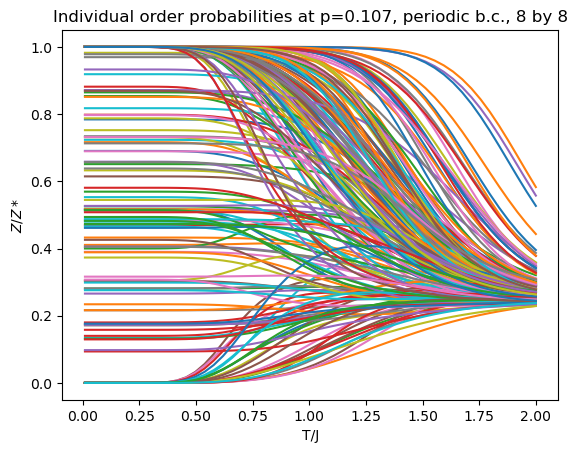

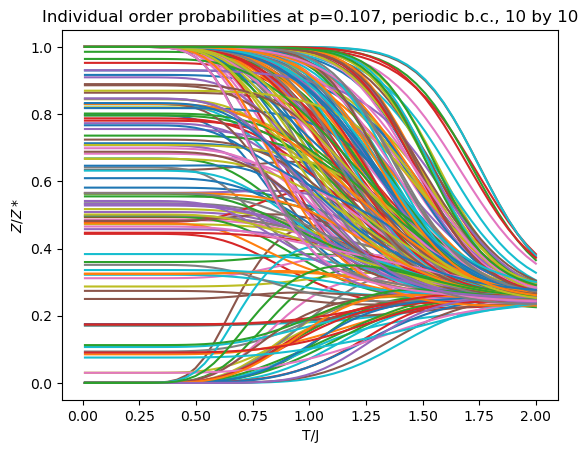

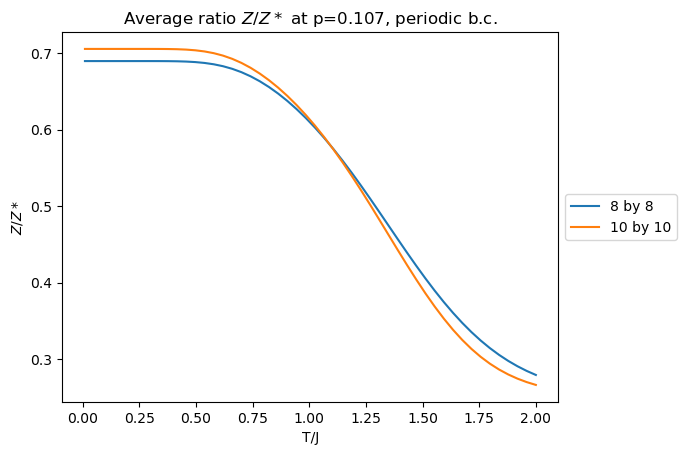

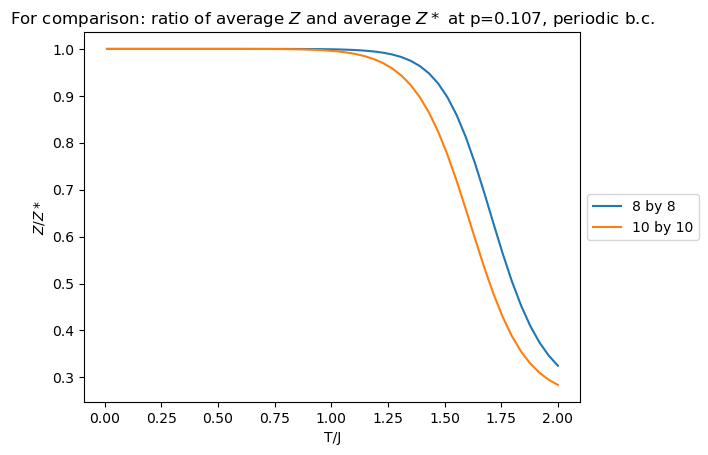

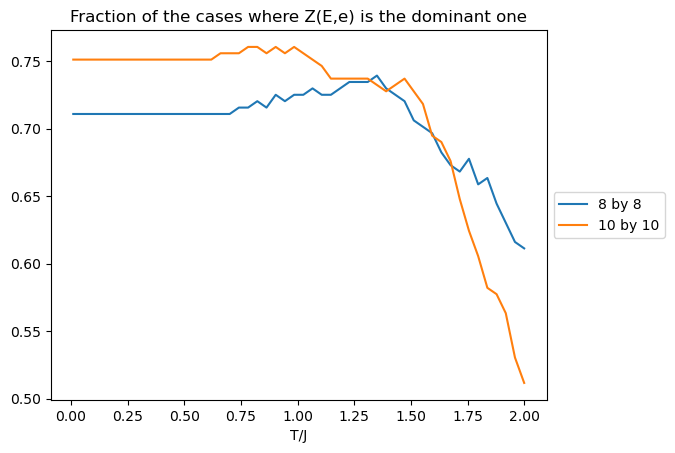

In [117]:

def free_energy(E_list, log_g_list,  T):
    #Need to log sum over g(E)*exp(-E/T) without overflow issues   
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res

def get_free_energies(rescaled_results,temperatures):
    free_energies = []
    for seed_results in rescaled_results:
        free_energy_classes = []
        for error_result in seed_results:    
            f_values = []
            for T in temperatures:
                f_values.append(free_energy(error_result[0], error_result[1], T)/(-T))
            free_energy_classes.append(f_values)
        free_energies.append(free_energy_classes)
    return free_energies



for max_temp in [2]:

    temperatures = np.linspace(0.01,max_temp,50)
    free_energies_10 = get_free_energies(rescaled_results_10,temperatures)
    free_energies_8 = get_free_energies(rescaled_results_8,temperatures)

    plt.figure() 
    for f_class in free_energies_8:
        plt.plot(temperatures, [1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                                  +mp.exp(f_class[2][j] - f_class[0][j])\
                                  +mp.exp(f_class[3][j] - f_class[0][j])) \
                                for j in range(len(f_class[0]))])
    plt.title("Individual order probabilities at p=0.107, periodic b.c., 8 by 8")
    plt.ylabel(r"$Z/Z*$")
    plt.xlabel("T/J")
    plt.show()
    
    plt.figure() 
    for f_class in free_energies_10:
        plt.plot(temperatures, [1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                                  +mp.exp(f_class[2][j] - f_class[0][j])\
                                  +mp.exp(f_class[3][j] - f_class[0][j])) \
                                for j in range(len(f_class[0]))])
    plt.title("Individual order probabilities at p=0.107, periodic b.c., 10 by 10")
    plt.ylabel(r"$Z/Z*$")
    plt.xlabel("T/J")
    plt.show()


    ####################
    # We check the average of the ratio of Z
    
    plt.figure() 
    plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                              +mp.exp(f_class[2][j] - f_class[0][j])\
                              +mp.exp(f_class[3][j] - f_class[0][j])) \
                                       for f_class in free_energies_8 ])/len(free_energies_8)  \
                            for j in range(len(f_class[0]))], label="8 by 8")
    plt.plot(temperatures,  [  np.sum([1/(1+ mp.exp(f_class[1][j] - f_class[0][j])\
                              +mp.exp(f_class[2][j] - f_class[0][j])\
                              +mp.exp(f_class[3][j] - f_class[0][j])) \
                                       for f_class in free_energies_10 ])/len(free_energies_10)  \
                            for j in range(len(f_class[0]))], label="10 by 10")
    plt.title(r"Average ratio $Z/Z*$ at p=0.107, periodic b.c.")
    plt.ylabel(r"$Z/Z*$")
    plt.xlabel("T/J")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    
    #We also want to check the order probability of the average, ie ratio of average Z

    plt.figure()
    
    f_class = free_energies_8[0]
    
    average_I = [log_sum_exp([f_class[0][j] for f_class in free_energies_8])  for j in range(len(f_class[0]))]
    average_X = [log_sum_exp([f_class[1][j] for f_class in free_energies_8])  for j in range(len(f_class[0]))]
    average_Y = [log_sum_exp([f_class[2][j] for f_class in free_energies_8])  for j in range(len(f_class[0]))]
    average_Z = [log_sum_exp([f_class[3][j] for f_class in free_energies_8])  for j in range(len(f_class[0]))]
    average_all = [log_sum_exp([average_I[j],average_X[j],average_Y[j],average_Z[j]]) for j in range(len(average_I))]
    
    plt.plot(temperatures, [mp.exp(average_I[j] - average_all[j]) for j in range(len(average_I))],label="8 by 8")
    
    
    f_class = free_energies_10[0]

    average_I = [log_sum_exp([f_class[0][j] for f_class in free_energies_10])  for j in range(len(f_class[0]))]
    average_X = [log_sum_exp([f_class[1][j] for f_class in free_energies_10])  for j in range(len(f_class[0]))]
    average_Y = [log_sum_exp([f_class[2][j] for f_class in free_energies_10])  for j in range(len(f_class[0]))]
    average_Z = [log_sum_exp([f_class[3][j] for f_class in free_energies_10])  for j in range(len(f_class[0]))]
    average_all = [log_sum_exp([average_I[j],average_X[j],average_Y[j],average_Z[j]]) for j in range(len(average_I))]

    plt.plot(temperatures, [mp.exp(average_I[j] - average_all[j]) for j in range(len(average_I))],label="10 by 10")

    plt.title(r"For comparison: ratio of average $Z$ and average $Z*$ at p=0.107, periodic b.c.")
    plt.ylabel(r"$Z/Z*$")
    plt.xlabel("T/J")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
 

    ############
    #For comparison, we also count how often any individual ratio is off.

    plt.figure()
    plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
               or f_class[0][j] < f_class[2][j]\
               or f_class[0][j] < f_class[3][j] for f_class in free_energies_8])/(len(free_energies_8))\
                            for j in range(len(f_class[0])) ] , label = "8 by 8")
    plt.plot(temperatures, [1 - sum([f_class[0][j] < f_class[1][j]\
               or f_class[0][j] < f_class[2][j]\
               or f_class[0][j] < f_class[3][j] for f_class in free_energies_10])/(len(free_energies_10))\
                            for j in range(len(f_class[0])) ] , label = "10 by 10")
    plt.title("Fraction of the cases where Z(E,e) is the dominant one")
    plt.xlabel("T/J")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
